In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_lfw_pairs
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
import warnings
warnings.filterwarnings('ignore')

In [30]:
# Fixer les seeds pour la reproductibilité
np.random.seed(42)
import random
random.seed(42)

# Configuration des styles de visualisation
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 2. Chargement des données LFW pairs
# Chargement du jeu de données LFW pairs
lfw_pairs = fetch_lfw_pairs(
    subset='train',
    color=False,
    resize=0.5
)

# Extraction des données et des cibles
X = lfw_pairs.data
y = lfw_pairs.target

print("=== Informations sur le jeu de données LFW pairs ===")
print(f"Nombre total d'échantillons: {X.shape[0]}")
print(f"Nombre de features par échantillon: {X.shape[1]}")
print(f"Distribution des classes: {np.bincount(y)}")
print(f"Classe 0 (personnes différentes): {np.sum(y == 0)}")
print(f"Classe 1 (même personne): {np.sum(y == 1)}")

# Détermination des dimensions des images
# Pour LFW avec resize=0.5, les dimensions sont 62x47 pixels
# Total features = 2 * 62 * 47 = 5828
total_features = X.shape[1]
features_per_image = total_features // 2

# Les dimensions standard pour LFW avec resize=0.5 sont 62x47
if features_per_image == 62 * 47:
    image_height, image_width = 62, 47
    print(f"\nDimensions confirmées: {image_height}x{image_width}")
else:
    # Calculer les dimensions
    for h in range(50, 150):
        for w in range(30, 100):
            if h * w == features_per_image:
                image_height, image_width = h, w
                print(f"\nDimensions calculées: {image_height}x{image_width}")
                break
        if image_height * image_width == features_per_image:
            break

print(f"Features par image: {features_per_image}")

# Fonction pour reconstruire les images
def reconstruct_images(data_sample, height=image_height, width=image_width):
    """
    Reconstruit les 2 images à partir d'un échantillon de données aplati
    """
    features_per_image = height * width
    image1 = data_sample[:features_per_image].reshape(height, width)
    image2 = data_sample[features_per_image:].reshape(height, width)
    return image1, image2

# Test de reconstruction
try:
    test_image1, test_image2 = reconstruct_images(X[0])
    print(f"\nTest de reconstruction réussi!")
    print(f"Image 1 shape: {test_image1.shape}")
except Exception as e:
    print(f"Erreur: {e}")
    # Forcer les dimensions 62x47 qui sont standard pour LFW
    image_height, image_width = 62, 47

# Redéfinir la fonction avec les dimensions confirmées
def reconstruct_images(data_sample, height=image_height, width=image_width):
    features_per_image = height * width
    image1 = data_sample[:features_per_image].reshape(height, width)
    image2 = data_sample[features_per_image:].reshape(height, width)
    return image1, image2

=== Informations sur le jeu de données LFW pairs ===
Nombre total d'échantillons: 2200
Nombre de features par échantillon: 5828
Distribution des classes: [1100 1100]
Classe 0 (personnes différentes): 1100
Classe 1 (même personne): 1100

Dimensions confirmées: 62x47
Features par image: 2914

Test de reconstruction réussi!
Image 1 shape: (62, 47)


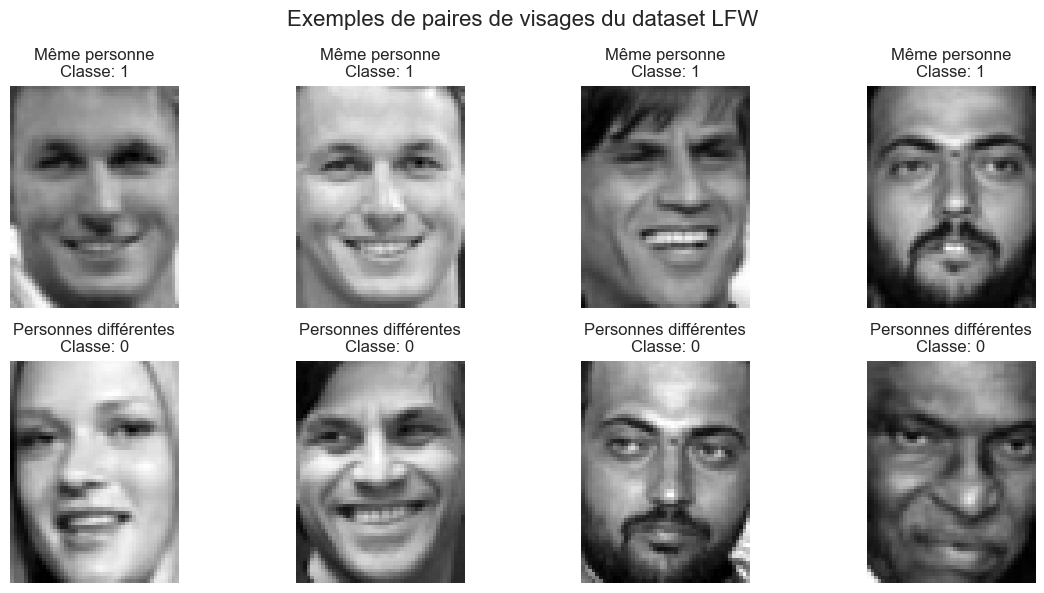


=== Analyse statistique ===
Moyenne des pixels: 0.48
Écart-type: 0.19
Min: 0.0, Max: 1.0


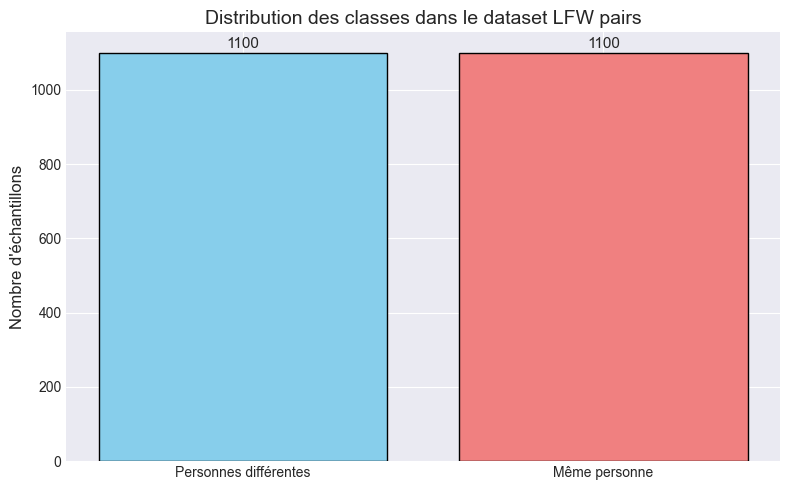

In [31]:
# 3. Exploration Rapide des Données (EDA)
# Visualisation d'exemples de paires de visages
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle('Exemples de paires de visages du dataset LFW', fontsize=16)

# Trouver des indices pour chaque classe
indices_same = np.where(y == 1)[0][:4]
indices_diff = np.where(y == 0)[0][:4]

for i in range(4):
    # Paire de la même personne (classe 1)
    idx_same = indices_same[i]
    image1_same, _ = reconstruct_images(X[idx_same])
    axes[0, i].imshow(image1_same, cmap='gray')
    axes[0, i].set_title(f'Même personne\nClasse: 1')
    axes[0, i].axis('off')
    
    # Paire de personnes différentes (classe 0)
    idx_diff = indices_diff[i]
    image1_diff, _ = reconstruct_images(X[idx_diff])
    axes[1, i].imshow(image1_diff, cmap='gray')
    axes[1, i].set_title(f'Personnes différentes\nClasse: 0')
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('lfw_examples.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyse statistique
print("\n=== Analyse statistique ===")
print(f"Moyenne des pixels: {X.mean():.2f}")
print(f"Écart-type: {X.std():.2f}")
print(f"Min: {X.min()}, Max: {X.max()}")

# Distribution des classes
plt.figure(figsize=(8, 5))
class_counts = pd.Series(y).value_counts()
bars = plt.bar(['Personnes différentes', 'Même personne'], class_counts.values, 
               color=['skyblue', 'lightcoral'], edgecolor='black')
plt.title('Distribution des classes dans le dataset LFW pairs', fontsize=14)
plt.ylabel('Nombre d\'échantillons', fontsize=12)

# Ajouter les valeurs sur les barres
for bar, count in zip(bars, class_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             str(count), ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [32]:
# 4. Prétraitement des données
# Normalisation (valeurs de pixels de 0 à 255)
X_normalized = X / 255.0

print("=== Après normalisation ===")
print(f"Moyenne: {X_normalized.mean():.3f}")
print(f"Écart-type: {X_normalized.std():.3f}")
print(f"Min: {X_normalized.min():.3f}")
print(f"Max: {X_normalized.max():.3f}")

# 5. Division des données
# Division train/test (80/20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_normalized, y, 
    test_size=0.2,
    random_state=42,
    stratify=y
)
# Division train/validation (75/25 du temp set)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.25,
    random_state=42,
    stratify=y_temp
)

print("=== Répartition des données ===")
print(f"Train: {X_train.shape[0]} ({100*X_train.shape[0]/len(X):.1f}%)")
print(f"Validation: {X_val.shape[0]} ({100*X_val.shape[0]/len(X):.1f}%)")
print(f"Test: {X_test.shape[0]} ({100*X_test.shape[0]/len(X):.1f}%)")

print(f"\nDistribution train: {np.bincount(y_train)}")
print(f"Distribution validation: {np.bincount(y_val)}")
print(f"Distribution test: {np.bincount(y_test)}")

# 6. Modèle Baseline
# Modèle baseline
baseline_model = DummyClassifier(strategy='most_frequent', random_state=42)
baseline_model.fit(X_train, y_train)

y_val_baseline_pred = baseline_model.predict(X_val)

# Évaluation
val_acc_baseline = accuracy_score(y_val, y_val_baseline_pred)
val_f1_baseline = f1_score(y_val, y_val_baseline_pred, zero_division=0)

print("=== Performances Baseline ===")
print(f"Accuracy (validation): {val_acc_baseline:.3f}")
print(f"F1-score (validation): {val_f1_baseline:.3f}")

# Matrice de confusion
baseline_cm = confusion_matrix(y_val, y_val_baseline_pred)
print(f"\nMatrice de confusion:")
print(baseline_cm)

=== Après normalisation ===
Moyenne: 0.002
Écart-type: 0.001
Min: 0.000
Max: 0.004
=== Répartition des données ===
Train: 1320 (60.0%)
Validation: 440 (20.0%)
Test: 440 (20.0%)

Distribution train: [660 660]
Distribution validation: [220 220]
Distribution test: [220 220]
=== Performances Baseline ===
Accuracy (validation): 0.500
F1-score (validation): 0.000

Matrice de confusion:
[[220   0]
 [220   0]]


Début de Grid Search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

=== Meilleurs hyperparamètres ===
{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Meilleur score F1: 0.608
=== Performances Random Forest ===

Accuracy - Train: 1.000, Val: 0.625, Test: 0.598
F1-score - Train: 1.000, Val: 0.595, Test: 0.608

=== Rapport de classification (test) ===
               precision    recall  f1-score   support

  Différentes       0.60      0.57      0.59       220
Même personne       0.59      0.62      0.61       220

     accuracy                           0.60       440
    macro avg       0.60      0.60      0.60       440
 weighted avg       0.60      0.60      0.60       440



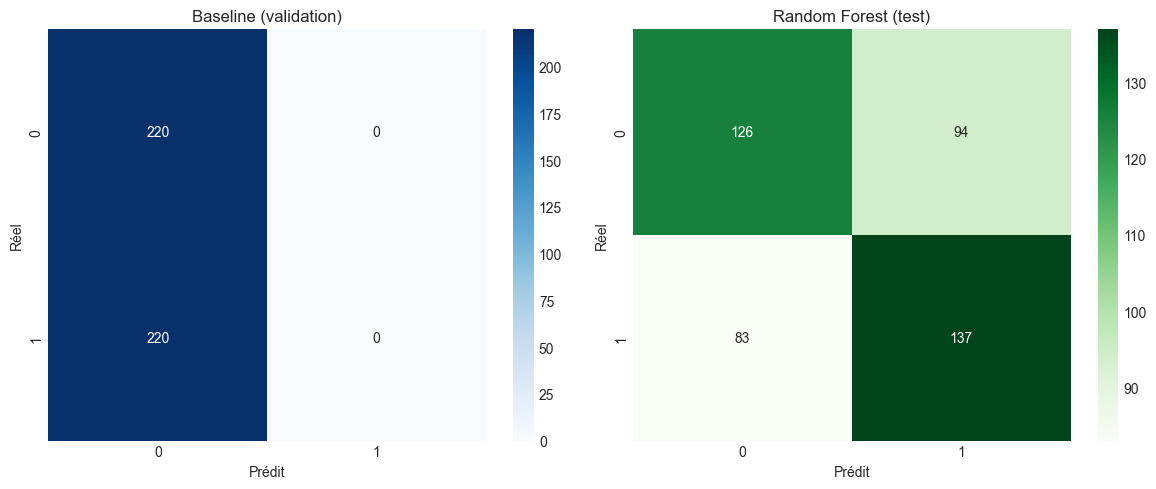

In [33]:
# 7. Random Forest avec Grid Search
# Modèle Random Forest initial
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Grille d'hyperparamètres simplifiée (pour accélérer l'exécution)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid Search
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=3,  # Réduit pour accélérer
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Début de Grid Search...")
grid_search.fit(X_train, y_train)

print("\n=== Meilleurs hyperparamètres ===")
print(grid_search.best_params_)
print(f"Meilleur score F1: {grid_search.best_score_:.3f}")

best_rf_model = grid_search.best_estimator_

# 8. Évaluation du modèle
# Prédictions
y_train_pred = best_rf_model.predict(X_train)
y_val_pred = best_rf_model.predict(X_val)
y_test_pred = best_rf_model.predict(X_test)

# Métriques
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

train_f1 = f1_score(y_train, y_train_pred)
val_f1 = f1_score(y_val, y_val_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("=== Performances Random Forest ===")
print(f"\nAccuracy - Train: {train_acc:.3f}, Val: {val_acc:.3f}, Test: {test_acc:.3f}")
print(f"F1-score - Train: {train_f1:.3f}, Val: {val_f1:.3f}, Test: {test_f1:.3f}")

# Rapport de classification
print("\n=== Rapport de classification (test) ===")
print(classification_report(y_test, y_test_pred, target_names=['Différentes', 'Même personne']))

# Matrices de confusion
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(baseline_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Baseline (validation)')
axes[0].set_xlabel('Prédit')
axes[0].set_ylabel('Réel')

rf_cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Random Forest (test)')
axes[1].set_xlabel('Prédit')
axes[1].set_ylabel('Réel')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

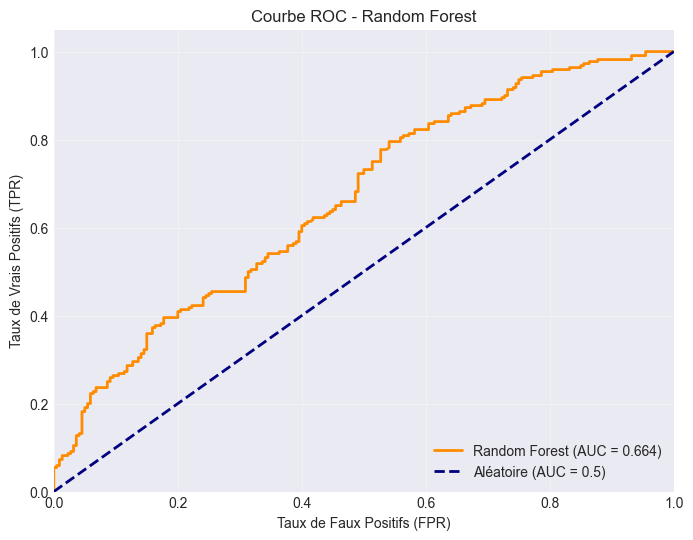

In [34]:
# 9. Courbes ROC
# Probabilités pour ROC
y_test_proba = best_rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Random Forest (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC - Random Forest')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

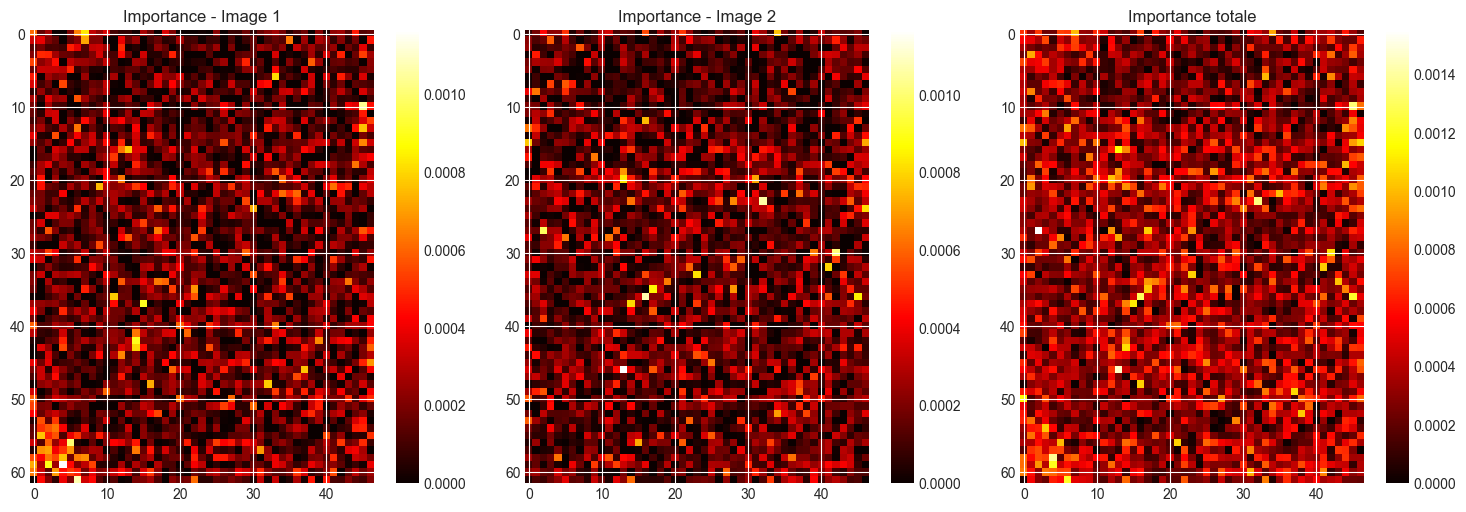

Top 10 features les plus importantes:
  Feature 1754: 0.00090
  Feature 4185: 0.00098
  Feature 2637: 0.00100
  Feature 4366: 0.00100
  Feature 515: 0.00104
  Feature 4027: 0.00106
  Feature 4622: 0.00107
  Feature 2873: 0.00107
  Feature 2777: 0.00117
  Feature 5089: 0.00117

Nombre d'erreurs: 177
Taux d'erreur: 40.23%


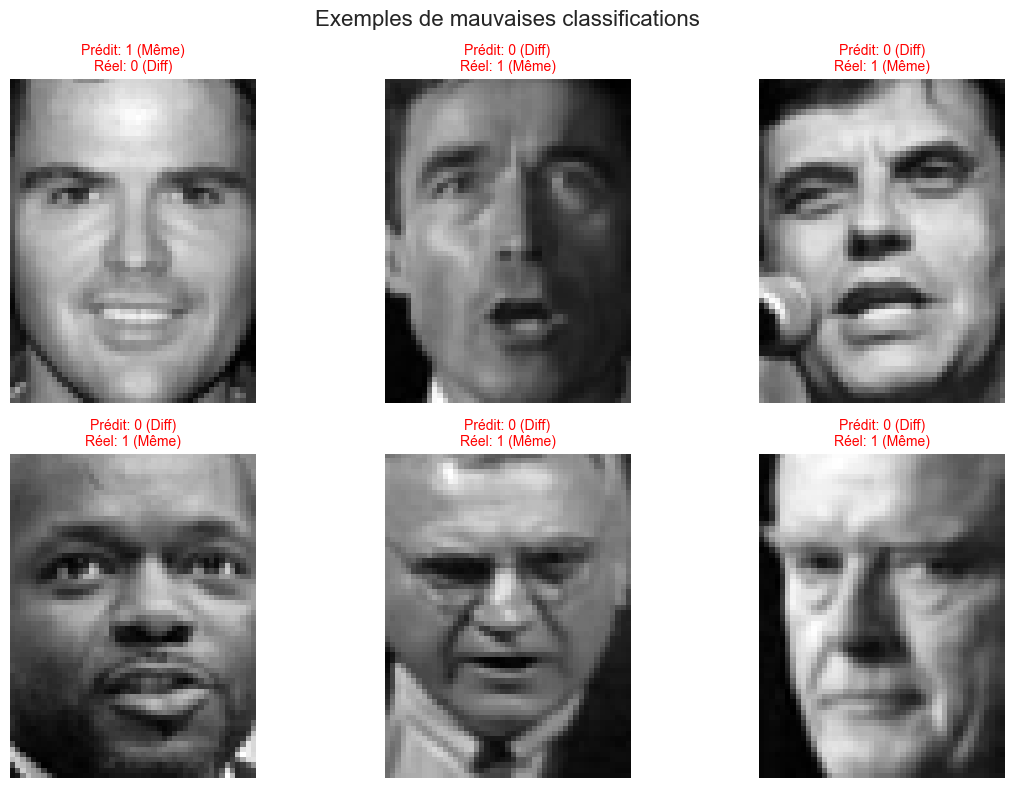

In [35]:
# 10. Interprétation

# Importance des features
feature_importances = best_rf_model.feature_importances_

# Reshape pour les images
importance_map = feature_importances.reshape(2, image_height, image_width)

# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im1 = axes[0].imshow(importance_map[0], cmap='hot')
axes[0].set_title('Importance - Image 1')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(importance_map[1], cmap='hot')
axes[1].set_title('Importance - Image 2')
plt.colorbar(im2, ax=axes[1])

im3 = axes[2].imshow(importance_map[0] + importance_map[1], cmap='hot')
axes[2].set_title('Importance totale')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Top features
top_features_idx = np.argsort(feature_importances)[-10:]
print("Top 10 features les plus importantes:")
for idx in top_features_idx:
    importance = feature_importances[idx]
    print(f"  Feature {idx}: {importance:.5f}")

# Erreurs de classification
misclassified_idx = np.where(y_test != y_test_pred)[0]

if len(misclassified_idx) > 0:
    print(f"\nNombre d'erreurs: {len(misclassified_idx)}")
    print(f"Taux d'erreur: {len(misclassified_idx)/len(y_test):.2%}")
    
    # Afficher quelques erreurs
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle('Exemples de mauvaises classifications', fontsize=16)
    
    for i in range(min(6, len(misclassified_idx))):
        idx = misclassified_idx[i]
        row = i // 3
        col = i % 3
        
        # Reconstruire l'image
        test_sample = X_test[idx] * 255.0
        image1, _ = reconstruct_images(test_sample)
        
        axes[row, col].imshow(image1, cmap='gray')
        
        pred = y_test_pred[idx]
        true = y_test[idx]
        color = 'red' if pred != true else 'green'
        
        axes[row, col].set_title(f'Prédit: {pred} ({"Même" if pred==1 else "Diff"})\n'
                                f'Réel: {true} ({"Même" if true==1 else "Diff"})',
                                color=color, fontsize=10)
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.savefig('misclassified_examples.png', dpi=300, bbox_inches='tight')
    plt.show()

In [36]:

# ## 11. Validation croisée
# Validation croisée sur l'ensemble complet
cv_scores = cross_val_score(
    best_rf_model, 
    X_normalized,
    y, 
    cv=5,
    scoring='f1',
    n_jobs=-1
)

print("=== Validation croisée (5-fold) ===")
print(f"Scores: {cv_scores}")
print(f"Moyenne: {cv_scores.mean():.3f}")
print(f"Écart-type: {cv_scores.std():.3f}")

# ## 12. Conclusion
# Tableau comparatif
results_df = pd.DataFrame({
    'Modèle': ['Baseline', 'Random Forest'],
    'Accuracy': [val_acc_baseline, test_acc],
    'F1-score': [val_f1_baseline, test_f1],
    'AUC': [0.5, roc_auc]
})

print("=== Résultats comparatifs ===")
print(results_df.to_string(index=False))


=== Validation croisée (5-fold) ===
Scores: [0.58079625 0.58108108 0.62162162 0.60606061 0.61428571]
Moyenne: 0.601
Écart-type: 0.017
=== Résultats comparatifs ===
       Modèle  Accuracy  F1-score      AUC
     Baseline  0.500000  0.000000 0.500000
Random Forest  0.597727  0.607539 0.664277
